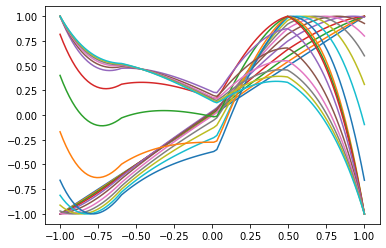

In [133]:
from matplotlib import pyplot as plt
import numpy as np
import random
import pyaudio
import math
import struct
from scipy.signal import sawtooth, square

#CHANGEME

coefficient_range = [-10,10] #range of polynomial coefficients, too large might cause clicks
poly_degree = 4 #max degree of polynomials, too large might cause clicks

pieces = 5  #number of different polynomials to stitch together

sequence_length = 20  #Length of function sequence. 0 means identity function only. 
                      #Graphs will be plotted for sequence_length < 10 only.

frequency = 220
total_duration = 5000 #total duration of sound

waveform = "sine" #, "saw" , "tri" and "square" all work atm.


#INITIALISE


#GENERATE CANDIDATE FUNCTIONS

poly_intervals = np.sort(np.append(np.random.uniform(low=-1.0, high=1.0, size=pieces-1),[-1,1])) #the piecewise interval points

random_coefficients = np.zeros((pieces, poly_degree+1, sequence_length+1))

for i in range(pieces):
    random_coefficients[i,poly_degree-1,0] = 1

random_coefficients[:,:,sequence_length] = np.random.uniform(low=coefficient_range[0], high=coefficient_range[1], size=(pieces,poly_degree+1)) #random matrix to draw polynomials from
                
for i in range(1,pieces):
    test = np.polyval(random_coefficients[i-1,:,sequence_length],poly_intervals[i]) - np.polyval(random_coefficients[i,:,sequence_length],poly_intervals[i])
    random_coefficients[i,poly_degree,sequence_length] += test
    #glues next piece continuously onto previous piece

maximum = np.polyval(random_coefficients[0,:,sequence_length],-1)
minimum = maximum

for sample_in in np.linspace(-1, 1, num=10000): 
    for i in range(pieces):
        if sample_in < poly_intervals[i+1] and sample_in >= poly_intervals[i]: 
            region = i
    maximum = max(np.polyval(random_coefficients[region,:,sequence_length],sample_in), maximum)
    minimum = min(np.polyval(random_coefficients[region,:,sequence_length],sample_in), minimum)

for i in range(pieces):
    if minimum < 0:
        random_coefficients[i,poly_degree,sequence_length] += abs(minimum)
    else: random_coefficients[i,poly_degree,sequence_length] -= minimum
    random_coefficients[i,:,sequence_length] = (random_coefficients[i,:,sequence_length])*2/(maximum - minimum)
    random_coefficients[i,poly_degree,sequence_length] -= 1
    

###NORMALISE FINAL CURVE     
maximum = np.polyval(random_coefficients[0,:,sequence_length],-1)
minimum = maximum

for sample_in in np.linspace(-1, 1, num=10000): 
    for i in range(pieces):
        if sample_in < poly_intervals[i+1] and sample_in >= poly_intervals[i]: 
            region = i
    maximum = max(np.polyval(random_coefficients[region,:,sequence_length],sample_in), maximum)
    minimum = min(np.polyval(random_coefficients[region,:,sequence_length],sample_in), minimum)

###END NORMALISE FINAL CURVE   
    
for interp in range(1,sequence_length):
        for i in range(pieces):
            for j in range(poly_degree+1):
                random_coefficients[i,j,interp] = (random_coefficients[i,j,sequence_length] - random_coefficients[i,j,0]) * interp / sequence_length + random_coefficients[i,j,0]

                
#### NORMALISE INTERPOLATED CURVES
for interp in range(1,sequence_length):  
    maximum = np.polyval(random_coefficients[0,:,interp],-1)
    minimum = maximum
    for sample_in in np.linspace(-1, 1, num=10000): 
        for i in range(pieces):
            if sample_in < poly_intervals[i+1] and sample_in >= poly_intervals[i]: 
                region = i
        maximum = max(np.polyval(random_coefficients[region,:,interp],sample_in), maximum)
        minimum = min(np.polyval(random_coefficients[region,:,interp],sample_in), minimum)

    for i in range(pieces):
        if minimum < 0:
            random_coefficients[i,poly_degree,interp] += abs(minimum)
        else: random_coefficients[i,poly_degree,interp] -= minimum
        random_coefficients[i,:,interp] = (random_coefficients[i,:,interp])*2/(maximum - minimum)
        random_coefficients[i,poly_degree,interp] -= 1                

#### NORMALISE INTERPOLATED CURVES
    
    
region = 0

curves = np.zeros((sequence_length,100))

curves[sequence_length-1,0] = np.polyval(random_coefficients[0,:,sequence_length-1],-1)

A = np.linspace(-1, 1, num=100)

for seq in range(sequence_length):
    for sample_in in range(100): 
        for i in range(pieces):
            if A[sample_in] < poly_intervals[i+1] and A[sample_in] >= poly_intervals[i]: 
                region = i
        curves[seq,sample_in] = np.polyval(random_coefficients[region,:,seq],A[sample_in])



plt.figure(interp)

for i in range(sequence_length):    
        plt.plot(A,curves[i,:])

                                                      
# for i in range(sequence_length+1):
    
#     A,functions[:,interp])
#     plt.title("Deformation Function f" + str(interp))
#     plt.xlabel('x')
#     plt.ylabel("f(x)")


# def caller(x, interp):
#     called_val = np.where(A == x)[0][0] #Returns the position of the input amplitude in the amplitude array A
#     return(functions[called_val, interp])        #Outputs desired value f(x)

# #PLOT AUDIO

# def find_nearest(array, value):                #Allows any input to be rounded to the chosen bitrate, corresponding to a value in A
#     array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     return array[idx]

   
# def plotter(type, frequency, volume, duration):
#     for interp in range(sequence_length+1):
#         plotbuf = np.random.normal(loc=0, scale=1, size=int(float(duration / 1000.0)*samplerate))

#         if type == "sine":
#             dur = int(samplerate * float(duration / 1000.0))
#             theta = 0.0
#             incr_theta = frequency * 2 * math.pi / samplerate # frequency increment normalized for sample rate
#             for i in range(dur):
#                 plotbuf[i] = caller(find_nearest(A,volume * math.sin(theta)),interp)
#                 theta += incr_theta

#         if type == "saw":
#             dur = int(samplerate * float(duration / 1000.0))
#             theta = 0.0
#             incr_theta = frequency * 2 * math.pi / samplerate # frequency increment normalized for sample rate
#             for i in range(dur):
#                 plotbuf[i] = caller(find_nearest(A,volume * sawtooth(theta)),interp)
#                 theta += incr_theta

#         if type == "tri":
#             dur = int(samplerate * float(duration / 1000.0))
#             theta = 0.0
#             incr_theta = frequency * 2 * math.pi / samplerate # frequency increment normalized for sample rate
#             for i in range(dur):
#                 plotbuf[i] = caller(find_nearest(A,volume * sawtooth(theta, width = 0.5)),interp)
#                 theta += incr_theta     

#         if type == "square":
#             dur = int(samplerate * float(duration / 1000.0))
#             theta = 0.0
#             incr_theta = frequency * 2 * math.pi / samplerate # frequency increment normalized for sample rate
#             for i in range(dur):
#                 plotbuf[i] = caller(find_nearest(A,volume * square(theta)),interp)
#                 theta += incr_theta                   

#         #PLOT

#         #if sequence_length< 10: #doesn't produce a plot if sequence_length is too big - causes memory issues with Jupyter otherwise

#         period_scale = sequence_length//2 #how many quarter-cycles to show. 4 = a single full cycle.

#         axes = np.arange(0,2,1/period_scale/round(plotbuf.size/frequency))

#         #plt.figure(interp)   #plots transformed sine wave on Deformation Function graph
#         #plt.plot(axes-1,plotbuf[0:period_scale*2*round(plotbuf.size/frequency)])

#         plt.figure(sequence_length+2)    #plots all sine waves on single graph
#         plt.plot(axes,plotbuf[0:period_scale*2*round(plotbuf.size/frequency)])
#         plt.title("fn(" + waveform + "(x))")
#      i   plt.xlabel("phase in multiples of π")


In [121]:
np.random.uniform(low=-1.0, high=1.0, size=pieces-1)

array([-0.060932  ,  0.09456121, -0.80402925,  0.33396847])

In [32]:
with open(f'fns.txt', 'w+') as f:
    for i in range(sequence_length):
        fn = functions[:,i]
        f.write('\t'.join(map(lambda x: '%.9f' % x, list(fn))))
        if i < sequence_length - 1:
            f.write('\n')

In [22]:
list(map(str, functions[:,0]))

['-1.0',
 '-0.998046875',
 '-0.99609375',
 '-0.994140625',
 '-0.9921875',
 '-0.990234375',
 '-0.98828125',
 '-0.986328125',
 '-0.984375',
 '-0.982421875',
 '-0.98046875',
 '-0.978515625',
 '-0.9765625',
 '-0.974609375',
 '-0.97265625',
 '-0.970703125',
 '-0.96875',
 '-0.966796875',
 '-0.96484375',
 '-0.962890625',
 '-0.9609375',
 '-0.958984375',
 '-0.95703125',
 '-0.955078125',
 '-0.953125',
 '-0.951171875',
 '-0.94921875',
 '-0.947265625',
 '-0.9453125',
 '-0.943359375',
 '-0.94140625',
 '-0.939453125',
 '-0.9375',
 '-0.935546875',
 '-0.93359375',
 '-0.931640625',
 '-0.9296875',
 '-0.927734375',
 '-0.92578125',
 '-0.923828125',
 '-0.921875',
 '-0.919921875',
 '-0.91796875',
 '-0.916015625',
 '-0.9140625',
 '-0.912109375',
 '-0.91015625',
 '-0.908203125',
 '-0.90625',
 '-0.904296875',
 '-0.90234375',
 '-0.900390625',
 '-0.8984375',
 '-0.896484375',
 '-0.89453125',
 '-0.892578125',
 '-0.890625',
 '-0.888671875',
 '-0.88671875',
 '-0.884765625',
 '-0.8828125',
 '-0.880859375',
 '-0.87890

In [29]:
step

0.001953125